# Whole brain data processing

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing_single_WS import *
import scipy.ndimage.filters as sfilter

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
dir_root = '/nrs/ahrens/jing/giving_up/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/'

In [3]:
_ = np.load(save_root+'cell_raw_dff.npz', allow_pickle=True)
A = _['A']
dFF = _['dFF']
A_loc = _['A_loc']

In [4]:
brain_map = np.load(save_root+'Y_ave.npy')

In [5]:
cell_id = 175000
A_ = A[cell_id]
A_loc_ = A_loc[cell_id]
z, x, y = A_loc_
A_ext = np.zeros((brain_map.shape[1],brain_map.shape[2]))
A_ext[x:x+100, y:y+100]=A_

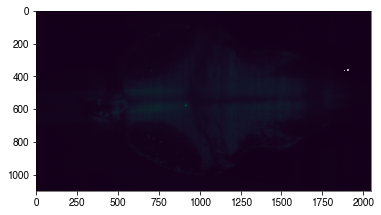

In [6]:
plt.imshow(brain_map[z].squeeze())
plt.imshow(A_ext>0, cmap='gray', alpha=0.7)

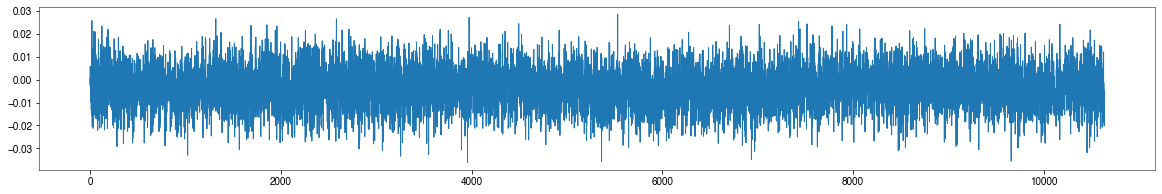

In [7]:
plt.figure(figsize=(20, 3))
plt.plot(dFF[cell_id])
plt.show()

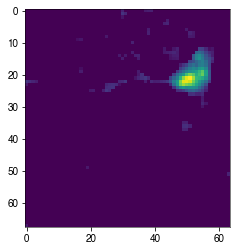

In [56]:
plt.imshow(A_[:dx, :dy])

# test using simple ROI

In [138]:
import zarr
dat_F = zarr.open(save_root+'motion_corrected_data.zarr', mode='r')
dat_dF = zarr.open(save_root+'detrend_data.zarr', mode='r')

In [139]:
_, dx, dy, _ = dat_F.chunks

In [140]:
ix = int(x/dx)
iy = int(y/dy)

In [141]:
from h5py import File

In [142]:
__ = File(save_root+'cell_raw_dff/period_Y_demix_block__%d_%d_%d_0_rlt.h5'%(z, ix, iy))

In [143]:
dFF_test = __['cell_dFF'].value

In [144]:
dFF_test.shape

(50, 10637)

In [146]:
# for n in range(A_test.shape[-1]):
#     print(n)
#     plt.imshow(A_test[:, :, n])
#     plt.show()

In [147]:
A__ = A_[:dx, :dy]

In [148]:
np.abs(A_test[:, :, 15]-A__).sum()

0.0

In [149]:
dat_crop_F = dat_F[z, x:x+dx, y:y+dy]
dat_crop_dF = dat_dF[z, x:x+dx, y:y+dy]

In [150]:
baseline_t = baseline_from_Yd(dat_crop_F, dat_crop_dF)

In [164]:
Y_d_max = brain_map.max(axis=0).squeeze()
mask_ = Y_d_max>np.percentile(Y_d_max, 35)

In [213]:
dat_crop_dF[~mask_[x:x+dx, y:y+dy].squeeze()] =0
baseline_t[~mask_[x:x+dx, y:y+dy].squeeze()] =0

In [262]:
A_test = __['A'].value

In [263]:
A_ = A_test.reshape(dx*dy,-1, order='F')

In [264]:
A_[A_<A_.max(axis=0, keepdims=True)*0.5]=0

In [271]:
s = A_<A_.max(axis=0, keepdims=True)*0.5

In [278]:
A_ = A_.reshape((dx, dy, -1), order="F")
A_sparse = A_.copy()
A_sparse[~mask_[x:x+dx, y:y+dy]]=0
A_sparse = A_sparse[:, :, (A_sparse>0).sum(axis=(0,1))>10]

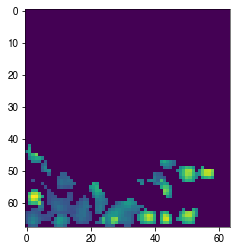

In [281]:
# for n in range(A_sparse.shape[-1]):
#     plt.imshow(A_sparse[:, :, n])
#     plt.show()
plt.imshow(A_sparse.sum(axis=-1))

In [265]:
A_test = A_[:, A_.sum(axis=0)>0]

In [266]:
A_test = A_test.reshape(dx, dy, -1, order='F')
A_test[~mask_[x:x+dx, y:y+dy].squeeze(), :]=0

In [267]:
A_test = A_test.reshape(dx*dy, -1, order='F')

In [236]:
inv_A = np.linalg.inv(A_test.reshape(dx*dy,-1, order='F').T.dot(A_test.reshape(dx*dy,-1, order='F')))

In [237]:
# F0 = inv_A.dot(A_test.reshape(dx*dy,-1, order='F').T.dot(baseline_t.reshape(dx*dy,-1, order='F')))
# dF = inv_A.dot(A_test.reshape(dx*dy,-1, order='F').T.dot(dat_crop_dF.reshape(dx*dy,-1, order='F')))

In [238]:
F0 = np.matmul(A_test.reshape(dx*dy,-1, order='F').T, baseline_t.reshape(dx*dy,-1, order='F'))
dF = np.matmul(A_test.reshape(dx*dy,-1, order='F').T, dat_crop_dF.reshape(dx*dy,-1, order='F'))

In [239]:
# F0 = inv_A.dot(F0)
# dF = inv_A.dot(dF)

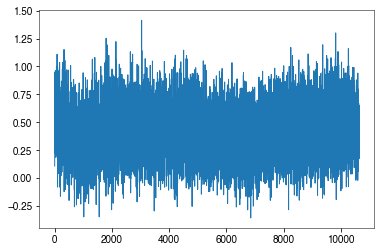

In [240]:
# plt.plot((dF/F0)[15].squeeze(), dFF_test[15], '.')
plt.plot((dF/F0)[14, :])

In [241]:
(dF/F0).shape

(43, 10637)

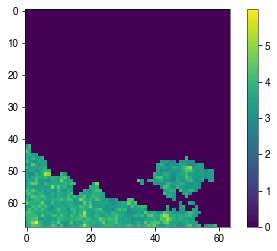

In [242]:
plt.imshow(dat_crop_dF.max(axis=-1))
plt.colorbar()
plt.show()

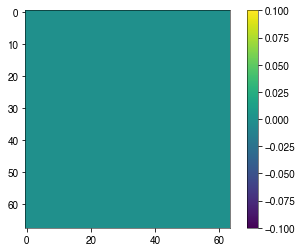

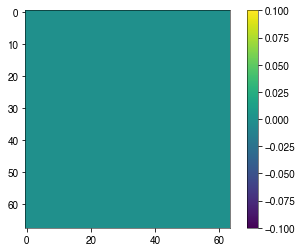

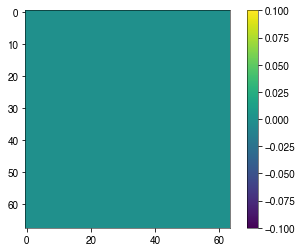

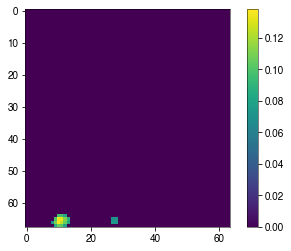

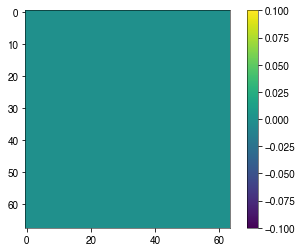

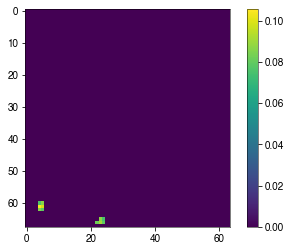

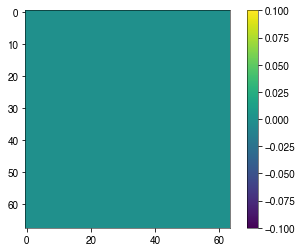

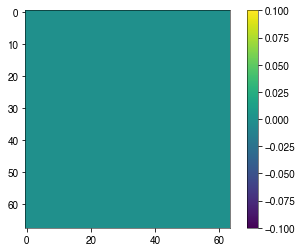

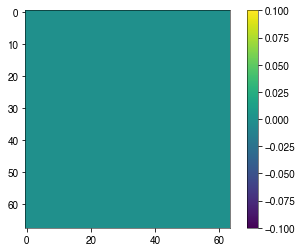

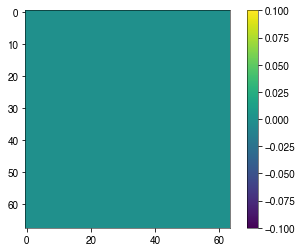

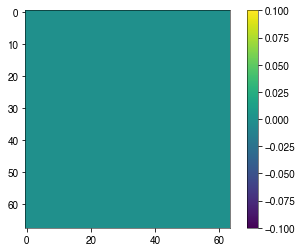

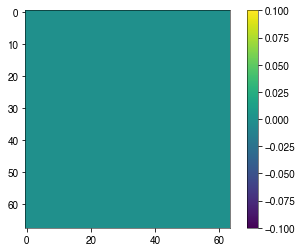

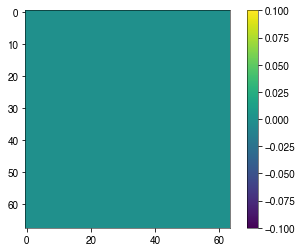

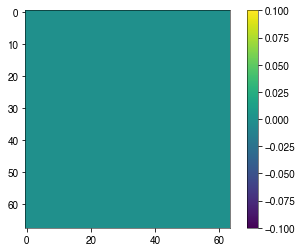

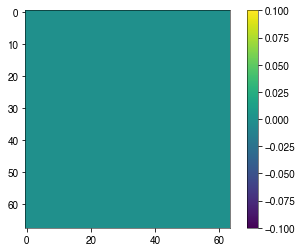

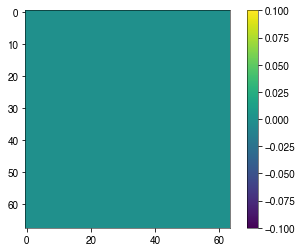

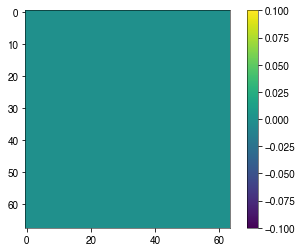

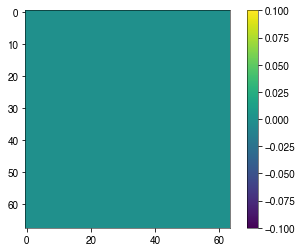

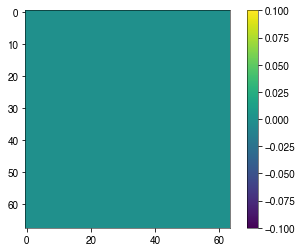

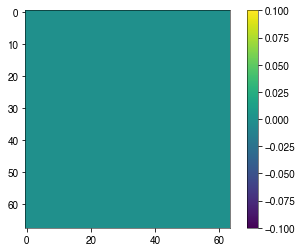

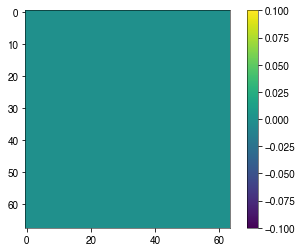

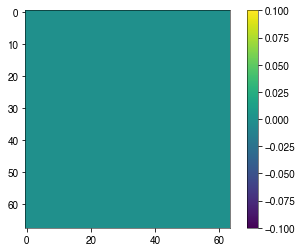

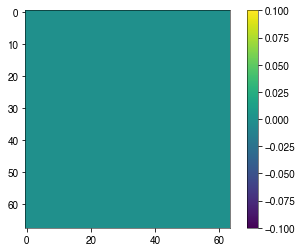

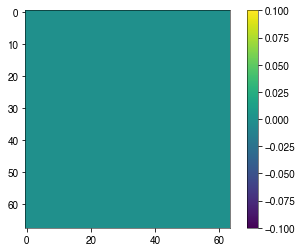

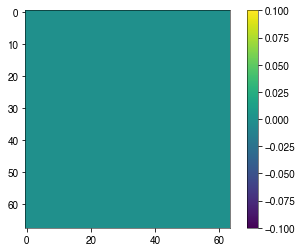

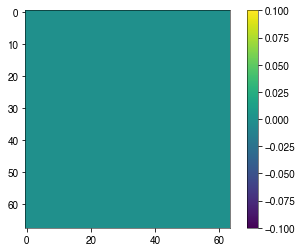

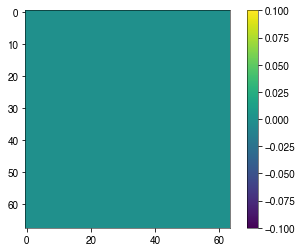

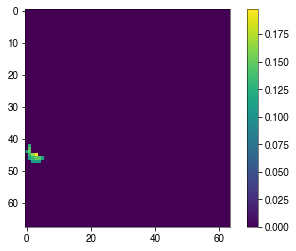

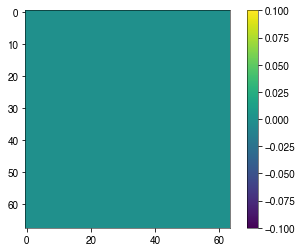

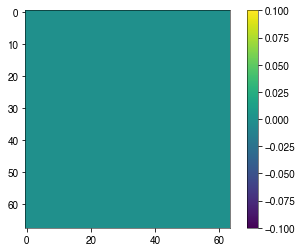

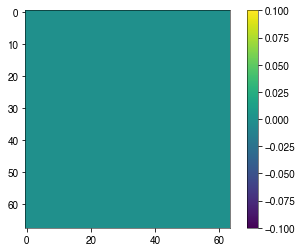

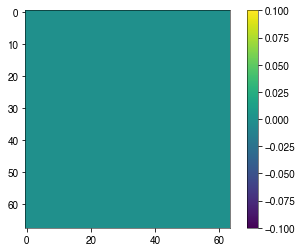

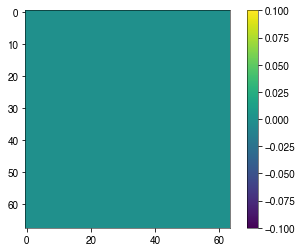

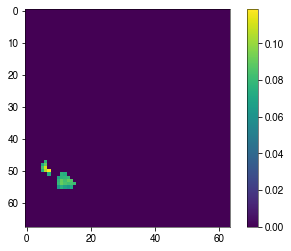

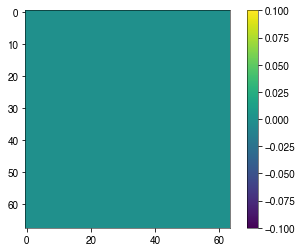

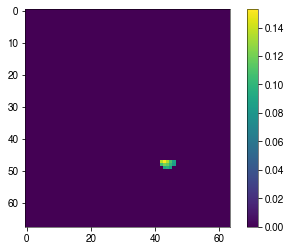

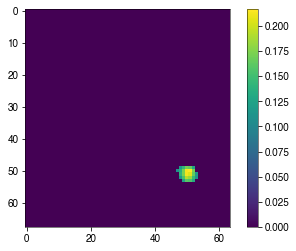

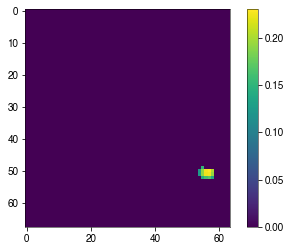

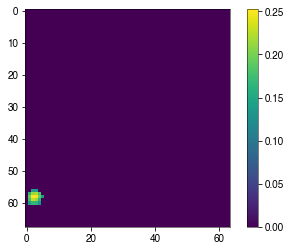

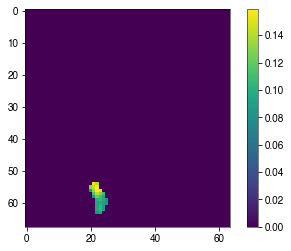

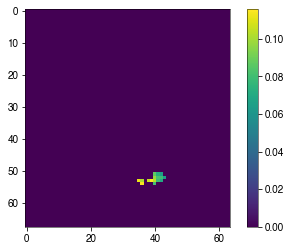

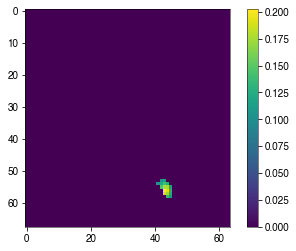

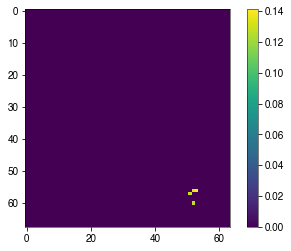

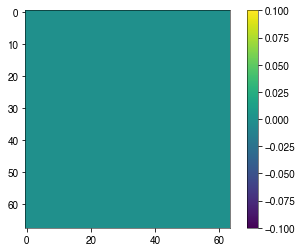

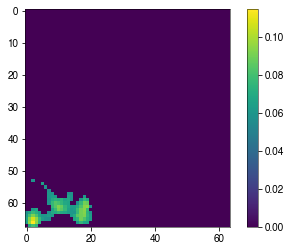

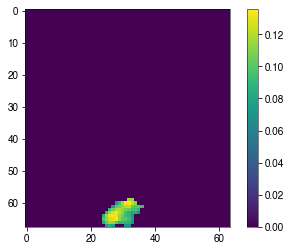

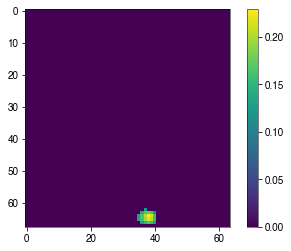

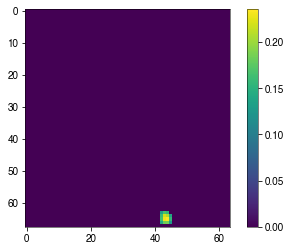

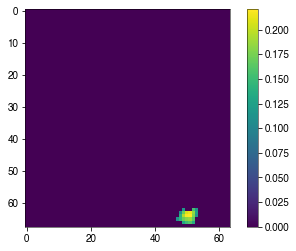

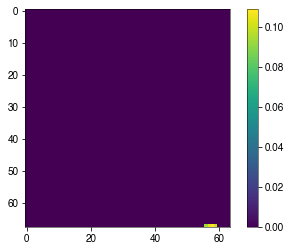

In [268]:
for n in range(A_test.shape[-1]):
    plt.imshow(A_test[:,n].reshape(dx, dy, order='F'))
    plt.colorbar()
    plt.show()

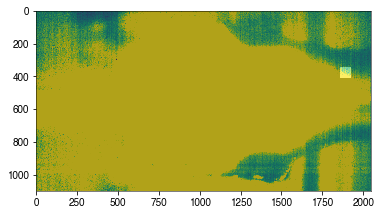

In [172]:
plt.imshow(brain_map[z].squeeze(), vmax=np.percentile(brain_map, 35))
mask_g = np.zeros((brain_map.shape[1],brain_map.shape[2]))
mask_g[x:x+dx, y:y+dx]=1
plt.imshow(mask_g, cmap='gray', alpha=0.3)

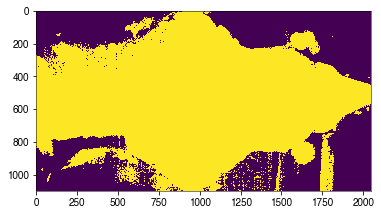

In [297]:
plt.imshow(mask_)

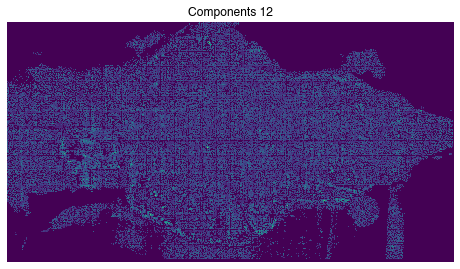

In [288]:
nsplit = (16, 32)
# for n in range(21):
n = 12
check_demix_cells_layer(save_root, n, nsplit=nsplit, mask=mask_)

(array([0.50542362, 0.5437833 , 0.58134597, 1.21417267, 0.60926524,
       0.67460509, 0.6600459 , 1.10810526, 1.06845251, 1.06502741,
       0.736919  , 0.7380656 , 0.75064829, 0.75434784, 1.03944907,
       0.76470611, 0.77085194, 0.77575167, 0.78743969, 0.78592775,
       1.02643067, 1.00970953, 0.81353854, 0.81689272, 0.82293326,
       0.99517797, 0.99236871, 0.98914039, 0.83563696, 0.98311776,
       0.97625572, 0.85178285, 0.96780297, 0.8613837 , 0.86266038,
       0.86318086, 0.86937483, 0.87719837, 0.87389451, 0.87264657,
       0.96245364, 0.95704083, 0.89342318, 0.95146188, 0.95132245,
       0.94525892, 0.94199711, 0.90115856, 0.9044142 , 0.90547692,
       0.91080199, 0.91245724, 0.91485765, 0.91638116, 0.92160199,
       0.92493737, 0.93718432, 0.92722737, 0.9333785 , 0.932273  ,
       0.93131821]), array([[-3.76646547e-02,  8.67007184e-01,  1.42220069e-01, ...,
         8.64699522e-03,  1.65359991e-03,  1.02918117e-03],
       [-8.20978525e-03, -4.26668861e-01, -8.17198

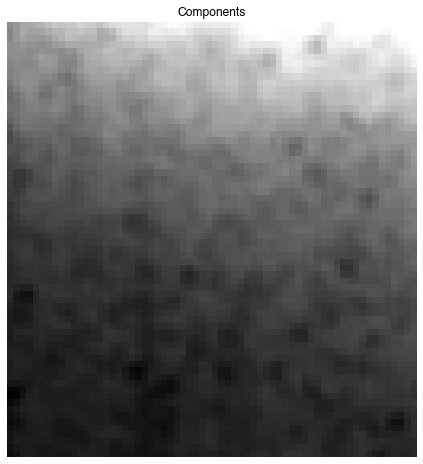

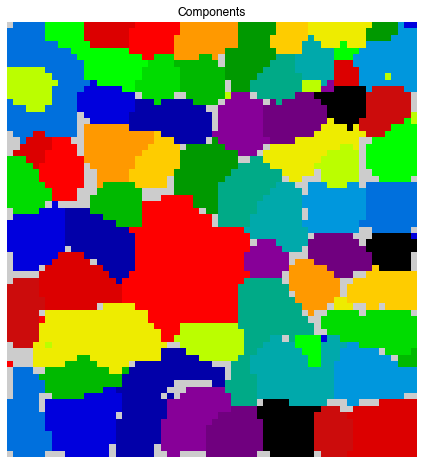

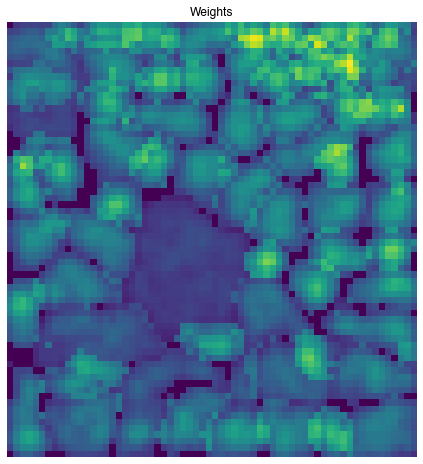

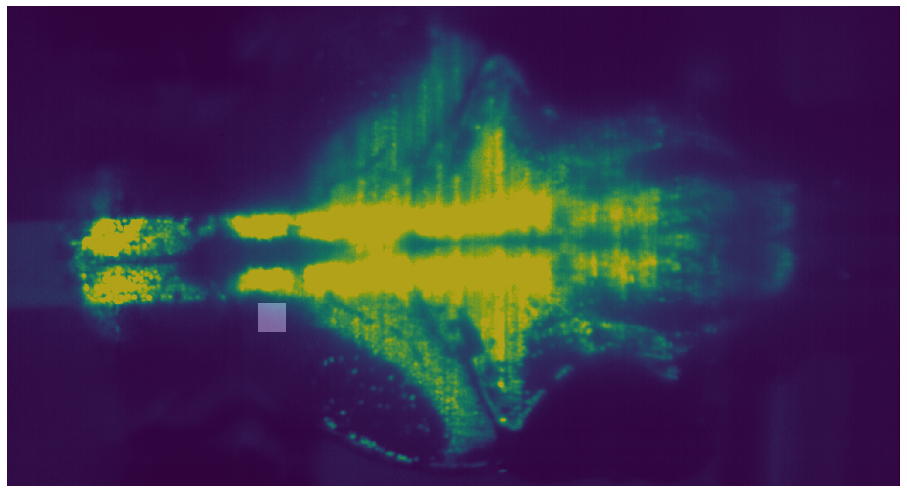

In [325]:
block_id = (10, 10, 9, 0)
check_demix_cells(save_root, block_id, mask=mask_)

In [293]:
A_ = load_A_matrix(save_root=save_root, block_id=block_id, min_size=0)

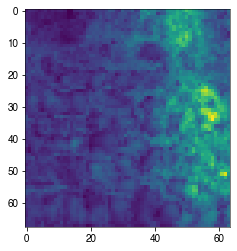

In [294]:
plt.imshow(A_.sum(axis=-1).reshape(dx, dy, order='F'))